# Análise do Ecossistema de IA em Python

**Autor(a):** Alice Maria Fonseca Victorino Freire

## 1. Introdução e Objetivos

Este projeto tem como objetivo modelar e analisar o ecossistema de bibliotecas de Inteligência Artificial em Python como um grafo de dependências. A partir de dados coletados de pacotes populares, exploramos a estrutura, as interconexões e as filosofias de design de diferentes domínios da IA, como Deep Learning, Manipulação de Dados, Visualização de Dados e Visão Computacional.

Conforme os objetivos do projeto, o trabalho seguirá as seguintes etapas:
1.  Criar uma base de dados a partir de um problema real (dependências de software).
2.  Transformar esta base de dados em um grafo.
3.  Analisar o grafo utilizando as métricas e conceitos vistos em aula.
4.  Visualizar os resultados de forma informativa.
5.  Organizar os artefatos em um formato reproduzível.
6.  Apresentar os resultados.

## 2. Configuração do Ambiente e Funções Auxiliares

Nesta seção, importamos todas as bibliotecas necessárias para o projeto e definimos as funções principais que serão reutilizadas ao longo da análise.

In [6]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import subprocess
import sys
from collections import Counter


# --- FUNÇÕES REUTILIZÁVEIS ---

def coletar_dados_bibliotecas(lista_de_bibliotecas, pasta_json='json_data'):
    """
    Instala um grupo de bibliotecas, gera seus arquivos de dependência em JSON
    e depois as desinstala para manter o ambiente limpo.
    Os arquivos JSON são salvos em uma subpasta para melhor organização.
    """
    # Garante que a pasta de destino para os JSONs exista
    os.makedirs(pasta_json, exist_ok=True)

    print(f"--- Iniciando coleta para: {', '.join(lista_de_bibliotecas)} ---")

    # Instala todas as ferramentas de uma vez para eficiência
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "pipdeptree", *lista_de_bibliotecas, "--quiet"],
        check=True
    )

    # Gera o JSON para cada biblioteca
    for lib in lista_de_bibliotecas:
        json_filepath = os.path.join(pasta_json, f"{lib.lower()}.json")
        print(f"Analisando '{lib}' -> salvando em '{json_filepath}'")
        try:
            with open(json_filepath, "w") as f:
                subprocess.run([sys.executable, '-m', 'pipdeptree', '-p', lib, '--json-tree'], stdout=f, check=True)
        except subprocess.CalledProcessError as e:
            print(f"!!! ATENÇÃO: Falha ao analisar '{lib}'. Pode não estar instalada corretamente ou não ser um pacote principal. Erro: {e}")
            # Cria um arquivo JSON vazio para não quebrar o fluxo
            with open(json_filepath, "w") as f:
                f.write("[]")


    # Limpa o ambiente
    subprocess.run(
        [sys.executable, "-m", "pip", "uninstall", "-y", "pipdeptree", *lista_de_bibliotecas, "--quiet"],
        check=True
    )
    print(f"✅ Coleta concluída.")


def carregar_e_combinar_grafos(lista_de_bibliotecas, tema, pasta_json='json_data'):
    """
    Carrega os arquivos JSON de uma lista de bibliotecas, atribui um tema
    a cada uma e combina tudo em um único grafo NetworkX.
    """
    G_combinado = nx.DiGraph()
    grafos_individuais = {}

    for lib in lista_de_bibliotecas:
        json_filepath = os.path.join(pasta_json, f"{lib.lower()}.json")

        # Função interna para carregar um único grafo
        G_individual = nx.DiGraph()
        try:
            with open(json_filepath, 'r') as f:
                content = f.read()
                if not content or content == "[]":
                    print(f"ATENÇÃO: Arquivo '{json_filepath}' está vazio ou não contém dados.")
                    continue
                data = json.loads(content)[0]

            def add_deps(node_data, parent_name):
                for dep in node_data.get('dependencies', []):
                    dep_name = dep['package_name']
                    G_individual.add_node(dep_name, version=dep.get('installed_version'))
                    G_individual.add_edge(parent_name, dep_name)
                    add_deps(dep, dep_name)

            root_name = data['package_name']
            G_individual.add_node(root_name, version=data['installed_version'], is_root=True)
            add_deps(data, root_name)

            # Atribui o "ecossistema" (a biblioteca raiz) e o "tema" a todos os nós do subgrafo
            for node in G_individual.nodes():
                G_individual.nodes[node]['ecosystem'] = lib
                G_individual.nodes[node]['tema'] = tema

            grafos_individuais[lib] = G_individual
            G_combinado.add_nodes_from(G_individual.nodes(data=True))
            G_combinado.add_edges_from(G_individual.edges())

        except Exception as e:
            print(f"Erro ao processar '{json_filepath}': {e}")

    # Identifica e marca os nós compartilhados dentro do tema
    all_nodes_list = [node for graph in grafos_individuais.values() for node in graph.nodes()]
    node_counts = Counter(all_nodes_list)
    common_nodes = {node for node, count in node_counts.items() if count > 1}
    for node in common_nodes:
        if node in G_combinado:
            G_combinado.nodes[node]['ecosystem'] = 'common'

    return G_combinado


def analisar_e_exportar(G, titulo):
    """
    Realiza a análise quantitativa de um grafo, gera a visualização da
    distribuição de grau e exporta o arquivo .gexf final para o Gephi.
    """
    print(f"\n--- Análise Quantitativa do Grafo: {titulo} ---")
    if G.number_of_nodes() == 0:
        print("Grafo vazio. Nenhuma análise a ser feita.")
        return

    print(f"Total de Nós: {G.number_of_nodes()}, Total de Arestas: {G.number_of_edges()}")

    # 1. DENSIDADE
    densidade = nx.density(G)
    print(f"[ DENSIDADE ]: {densidade:.6f}")

    # 2. ASSORTATIVIDADE DE GRAU
    assortatividade = nx.degree_assortativity_coefficient(G)
    print(f"[ ASSORTATIVIDADE ]: {assortatividade:.4f}")

    # 3. DISTRIBUIÇÃO DE GRAU
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    print(f"Grau máximo: {degree_sequence[0]}, Grau mínimo: {degree_sequence[-1]}")

    plt.figure(figsize=(12, 7))
    plt.hist(degree_sequence, bins=30, color="#2980b9")
    plt.title(f"Distribuição de Grau - {titulo}", fontsize=16)
    plt.ylabel("Número de Nós", fontsize=12)
    plt.xlabel("Grau (Número de Conexões)", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Exportação do GEXF para visualização no Gephi
    os.makedirs("gephi", exist_ok=True)
    gexf_filename = os.path.join("gephi", f"{titulo.lower().replace(' ', '_')}.gexf")
    nx.write_gexf(G, gexf_filename)
    print(f"✅ Grafo exportado para Gephi em: '{gexf_filename}' (abrir no Gephi)")

print("✅ Ambiente e funções preparados.")

✅ Ambiente e funções preparados.


## 3. Coleta de Dados

A célula abaixo executa o processo de coleta de dados. A função `coletar_dados_bibliotecas` foi projetada para instalar temporariamente cada biblioteca, analisar suas dependências com `pipdeptree`, salvar o resultado em um arquivo `.json` e, em seguida, desinstalar tudo.

**Atenção:** Esta etapa pode ser demorada e só precisa ser executada uma vez para gerar os arquivos-fonte. Se os arquivos `.json` já existirem na pasta `json_data`, você pode pular esta célula.

In [11]:
# Define todos os capítulos e bibliotecas que farão parte da análise
capitulos_para_coleta = {
    'Manipulação de Dados': ['pandas', 'numpy'],
    'Visualização de Dados': ['matplotlib', 'seaborn', 'plotly', 'altair'],
    'Visão Computacional': ['opencv-python', 'scikit-image', 'torchvision'],
    'Deep Learning': ['tensorflow', 'torch'],
    'Machine Learning Clássico': ['scikit-learn']
}

# Itera sobre cada capítulo e executa a função de coleta
for titulo, libs in capitulos_para_coleta.items():
    coletar_dados_bibliotecas(libs, pasta_json='json_data')

--- Iniciando coleta para: pandas, numpy ---
Analisando 'pandas' -> salvando em 'json_data\pandas.json'
Analisando 'numpy' -> salvando em 'json_data\numpy.json'
✅ Coleta concluída.
--- Iniciando coleta para: matplotlib, seaborn, plotly, altair ---
Analisando 'matplotlib' -> salvando em 'json_data\matplotlib.json'
Analisando 'seaborn' -> salvando em 'json_data\seaborn.json'
Analisando 'plotly' -> salvando em 'json_data\plotly.json'
Analisando 'altair' -> salvando em 'json_data\altair.json'


CalledProcessError: Command '['c:\\Users\\Alice\\projetos\\analise-dependencias-ia-python\\.venv\\Scripts\\python.exe', '-m', 'pip', 'uninstall', '-y', 'pipdeptree', 'matplotlib', 'seaborn', 'plotly', 'altair', '--quiet']' returned non-zero exit status 2.

## 4. Análise e Geração dos Grafos Temáticos

Agora que os dados brutos foram coletados e salvos em arquivos `.json`, esta célula irá processar cada tema ("capítulo") individualmente. Para cada tema, ela irá:
1.  Carregar os grafos de suas respectivas bibliotecas.
2.  Combiná-los em um único grafo temático.
3.  Executar e exibir a análise quantitativa (densidade, assortatividade, etc.).
4.  Gerar e exportar o arquivo `.gexf` final para visualização no Gephi.


 PROCESSANDO CAPÍTULO: VISUALIZAÇÃO DE DADOS

--- Análise Quantitativa do Grafo: Visualização de Dados ---
Total de Nós: 26, Total de Arestas: 33
[ DENSIDADE ]: 0.050769
[ ASSORTATIVIDADE ]: -0.1571
Grau máximo: 10, Grau mínimo: 1


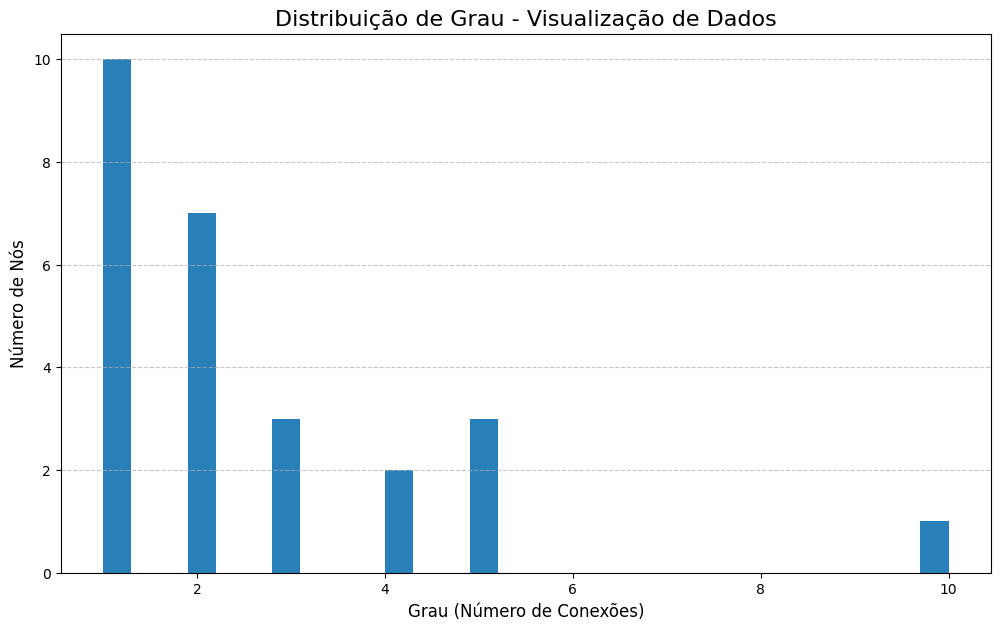

✅ Grafo exportado para Gephi em: 'gephi\visualização_de_dados.gexf' (abrir no Gephi)

 PROCESSANDO CAPÍTULO: VISÃO COMPUTACIONAL

--- Análise Quantitativa do Grafo: Visão Computacional ---
Total de Nós: 20, Total de Arestas: 26
[ DENSIDADE ]: 0.068421
[ ASSORTATIVIDADE ]: -0.4758
Grau máximo: 8, Grau mínimo: 1


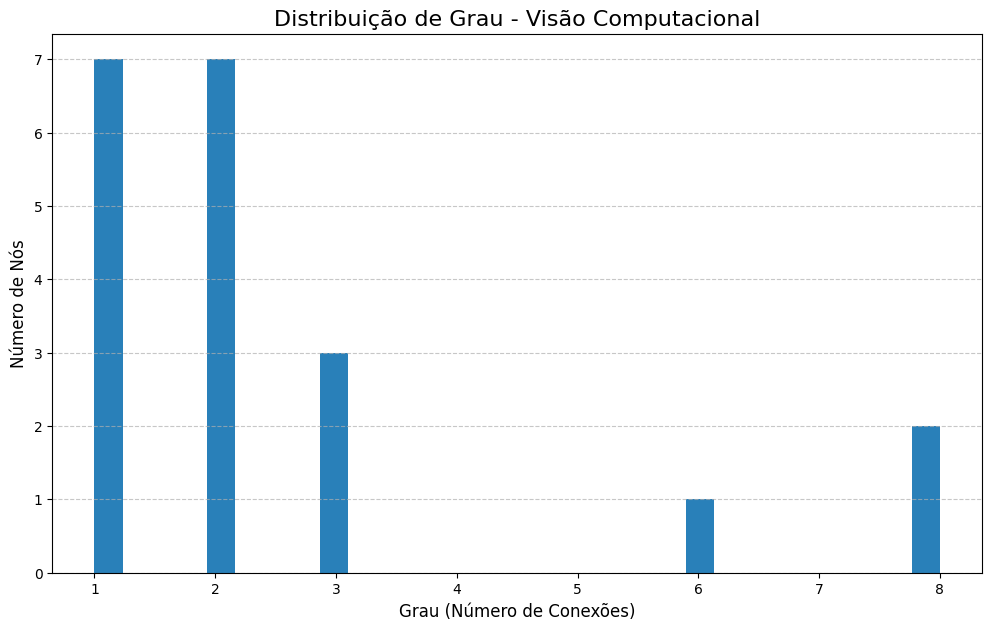

✅ Grafo exportado para Gephi em: 'gephi\visão_computacional.gexf' (abrir no Gephi)

 PROCESSANDO CAPÍTULO: DEEP LEARNING

--- Análise Quantitativa do Grafo: Deep Learning ---
Total de Nós: 45, Total de Arestas: 63
[ DENSIDADE ]: 0.031818
[ ASSORTATIVIDADE ]: -0.1021
Grau máximo: 21, Grau mínimo: 1


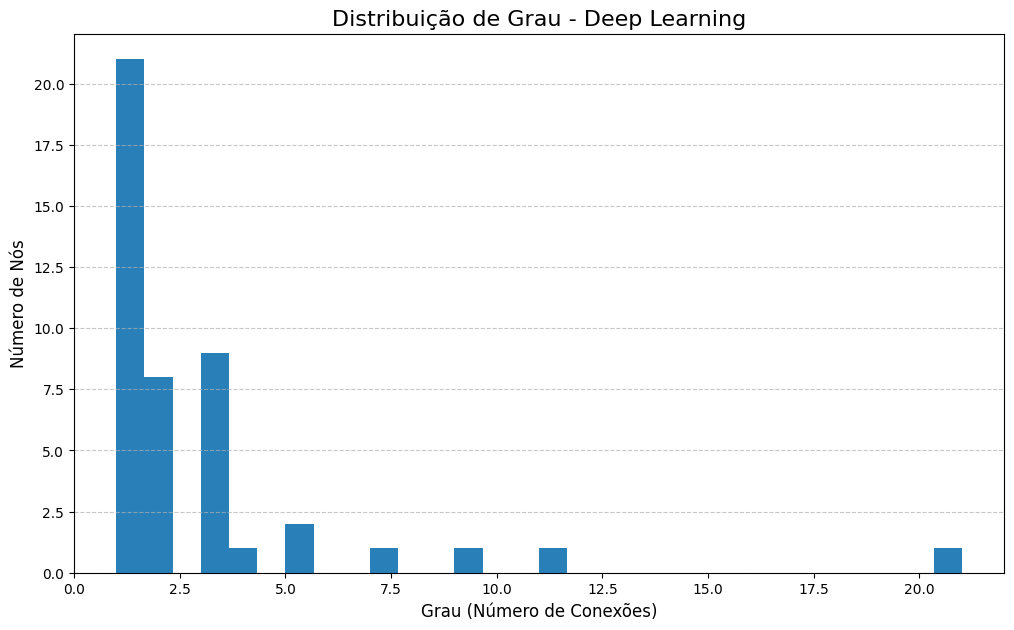

✅ Grafo exportado para Gephi em: 'gephi\deep_learning.gexf' (abrir no Gephi)


In [7]:
capitulos_para_grafo_individual = {
    'Visualização de Dados': ['matplotlib', 'seaborn', 'plotly', 'altair'],
    'Visão Computacional': ['opencv-python', 'scikit-image', 'torchvision'],
    'Deep Learning': ['tensorflow', 'torch'],
}

for titulo, libs in capitulos_para_grafo_individual.items():
    print(f"\n===================================================================")
    print(f" PROCESSANDO CAPÍTULO: {titulo.upper()}")

    # Carrega e combina os grafos para o tema atual
    grafo_tematico = carregar_e_combinar_grafos(libs, tema=titulo, pasta_json='json_data')

    # Realiza a análise completa e exporta os artefatos
    analisar_e_exportar(grafo_tematico, titulo)

## 5. Análise Final: O Grafo Unificado do Ecossistema

Como etapa final, vamos unificar todos os grafos temáticos em um único "grafo mestre". Isso nos dará uma visão panorâmica de todo o ecossistema de IA, revelando como os diferentes domínios se interconectam e quais são os pilares fundamentais que sustentam todas as áreas.


--- Análise Quantitativa do Grafo: Ecossistema IA Completo ---
Total de Nós: 74, Total de Arestas: 116
[ DENSIDADE ]: 0.021474
[ ASSORTATIVIDADE ]: -0.2097
Grau máximo: 21, Grau mínimo: 1


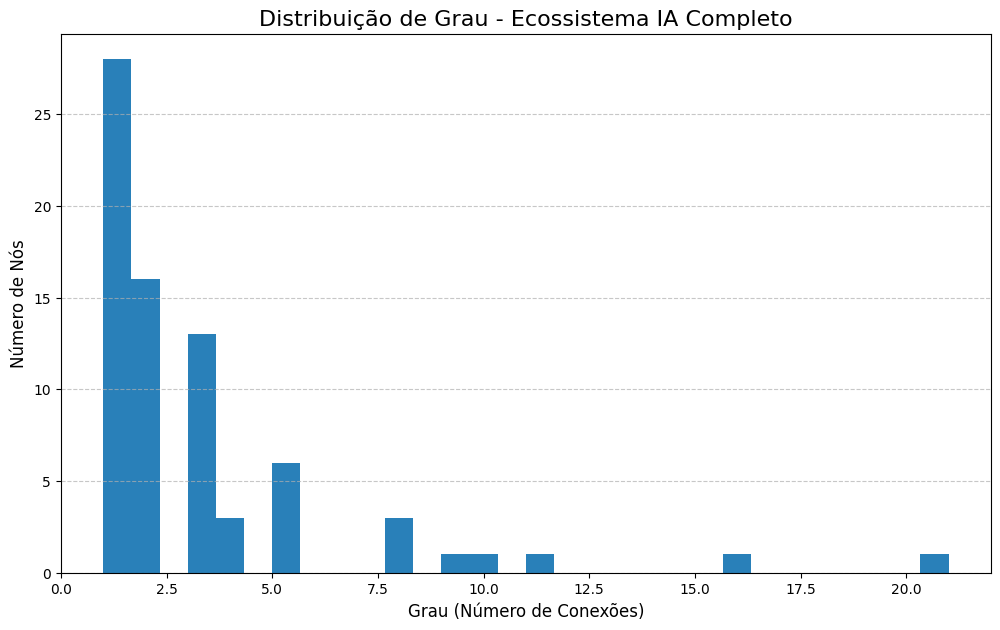

✅ Grafo exportado para Gephi em: 'gephi\ecossistema_ia_completo.gexf' (abrir no Gephi)


In [ ]:
G_master = nx.DiGraph()
todos_os_grafos_tematicos = []

for titulo, libs in capitulos_para_coleta.items():
    grafo_tematico = carregar_e_combinar_grafos(libs, tema=titulo, pasta_json='json_data')
    todos_os_grafos_tematicos.append(grafo_tematico)
    # Adicionamos ao grafo mestre
    G_master.add_nodes_from(grafo_tematico.nodes(data=True))
    G_master.add_edges_from(grafo_tematico.edges())

# Realiza a análise completa e exporta o grafo mestre
analisar_e_exportar(G_master, "Ecossistema IA Completo")